In [2]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rc("axes", labelsize=12)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)
plt.rcParams["figure.figsize"] = (20, 5)

import jupyter_black

jupyter_black.load(
    line_length=120,
    verbosity="DEBUG",
)

np.set_printoptions(precision=2)
%matplotlib inline
from IPython.display import display, Markdown, Latex, HTML, Image

import warnings

warnings.filterwarnings("ignore")
# from IPython.core.display import HTML

In [3]:
colors = ["red", "blue"]
cmap = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# 1- Datasets description

## 1-3 Loading Dataset

Load the data with np.load("filename.npz") and store the different matrices in memory (for in-
stance in variables x1,y1 for Pima data and x2,y2,xt2,yt2 for digits data). For the digits dataset,
it is better to perform one simple pre-processing that scales the values between [0, 1] by dividing the
data matrix by 255.

In [4]:
pima_df = np.load("pima.npz")
digits_df = np.load("digits.npz")

In [5]:
pima_x, pima_y = pima_df["xall"], pima_df["yall"]
pima_vars = pima_df["varnames"]
digits_xt, digits_yt, digits_x, digits_y = (
    digits_df["xt"] / 255,
    digits_df["yt"],
    digits_df["x"] / 255,
    digits_df["y"],
)

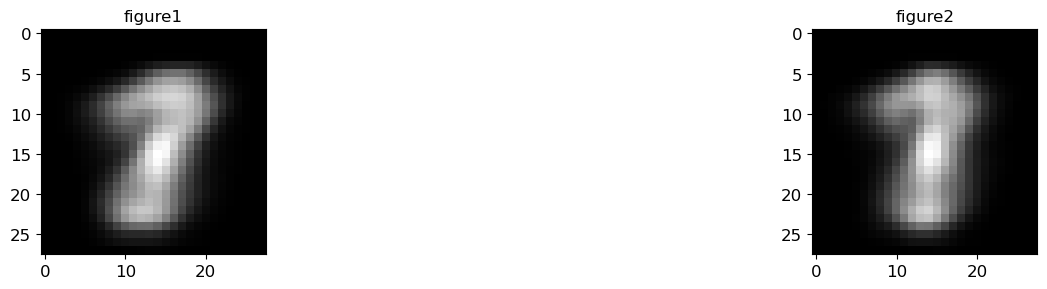

In [6]:
def plot_digits(digits, title="figure", title_list=[]):
    if len(digits) > 4:
        size = 1 + int((len(digits) - 0.005) / 4)
        fig, axs = plt.subplots(size, 4, figsize=(20, 3 * size))
        for i in range(len(digits)):
            axs[int(i / 4)][i % 4].imshow(digits[i].reshape(28, 28), cmap="gray")
            axs[int(i / 4)][i % 4].set_title(title + (str(i + 1) if not len(title_list) else str(title_list[i])))
    elif len(digits) > 1:
        fig, axs = plt.subplots(1, len(digits), figsize=(20, 3))
        for i in range(len(digits)):
            axs[i % 4].imshow(digits[i].reshape(28, 28), cmap="gray")
            axs[i % 4].set_title(title + (str(i + 1) if not len(title_list) else str(title_list[i])))
    else:
        plt.imshow(digits[0].reshape(28, 28), cmap="gray")
        plt.title(title + (str(1) if not len(title_list) else str(title_list[0])))
    plt.tight_layout()


plot_digits([digits_x.mean(0), digits_xt.mean(0)])

In [7]:
np.asmatrix([pima_x.mean(0), pima_x.std(0)]).T

matrix([[  3.75,   3.34],
        [121.61,  30.47],
        [ 69.64,  18.12],
        [ 20.77,  15.89],
        [ 80.53, 112.6 ],
        [ 32.45,   6.95],
        [  0.47,   0.33],
        [ 33.02,  11.66]])

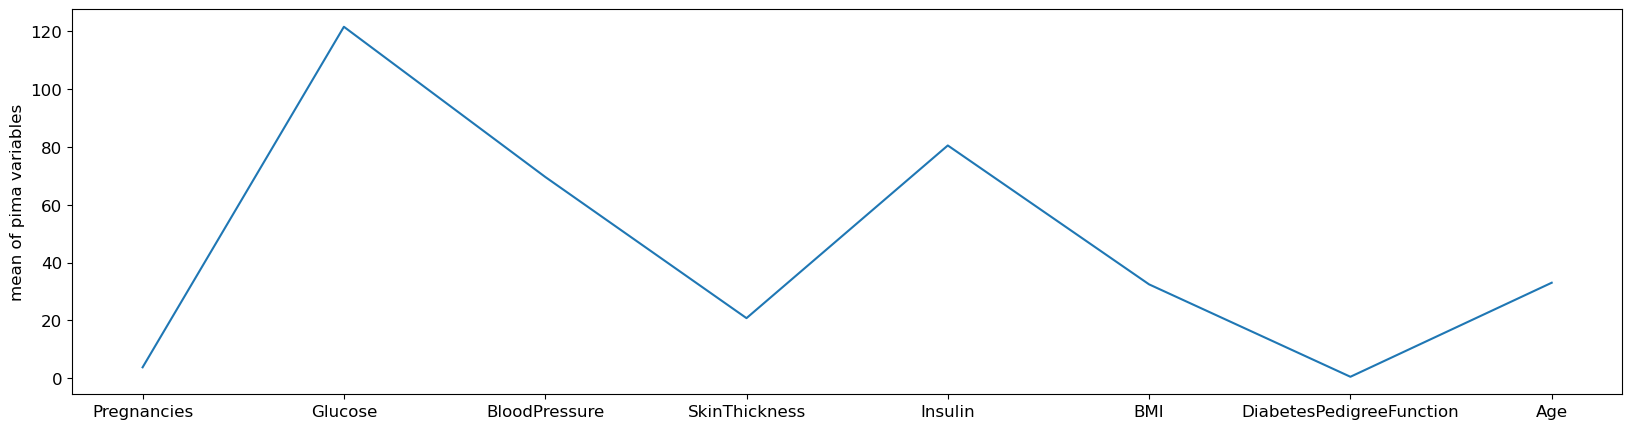

In [8]:
plt.figure()
plt.plot(pima_vars, pima_x.mean(0))
plt.ylabel("mean of pima variables");

we notice that the mean of variables is very different and for instance the mean of pregnancies is 3 which is normal in indea country, and glucose is 120 which is normal because a normal blood glucose level is lower than 155 mg/dL,
moreover bloodPressure has 70 as a mean , which is ideal because ideal blood pressure is usually considered to be between 90/60mmHg and 120/80mmHg,
-skinn tickness mean is 20.77 included in normal range of females The range of skin + subcutaneous tissue thickness at arm is 4.90-21.00 mm in females
- BMI mean is 32 , included in the normal range (If your BMI is 18.5 to 24.9, it falls within the normal or Healthy Weight range.)
- the mean age is 33 which normal

# 2-Predicting Diabetes on the Pima dataset

On this dataset we will evaluate the performance of the classifier with the accuracy and with the AUC.

## 2.1 Know the data

- Visualize the data as scatterplots between pairs of variables (where the color is the class).

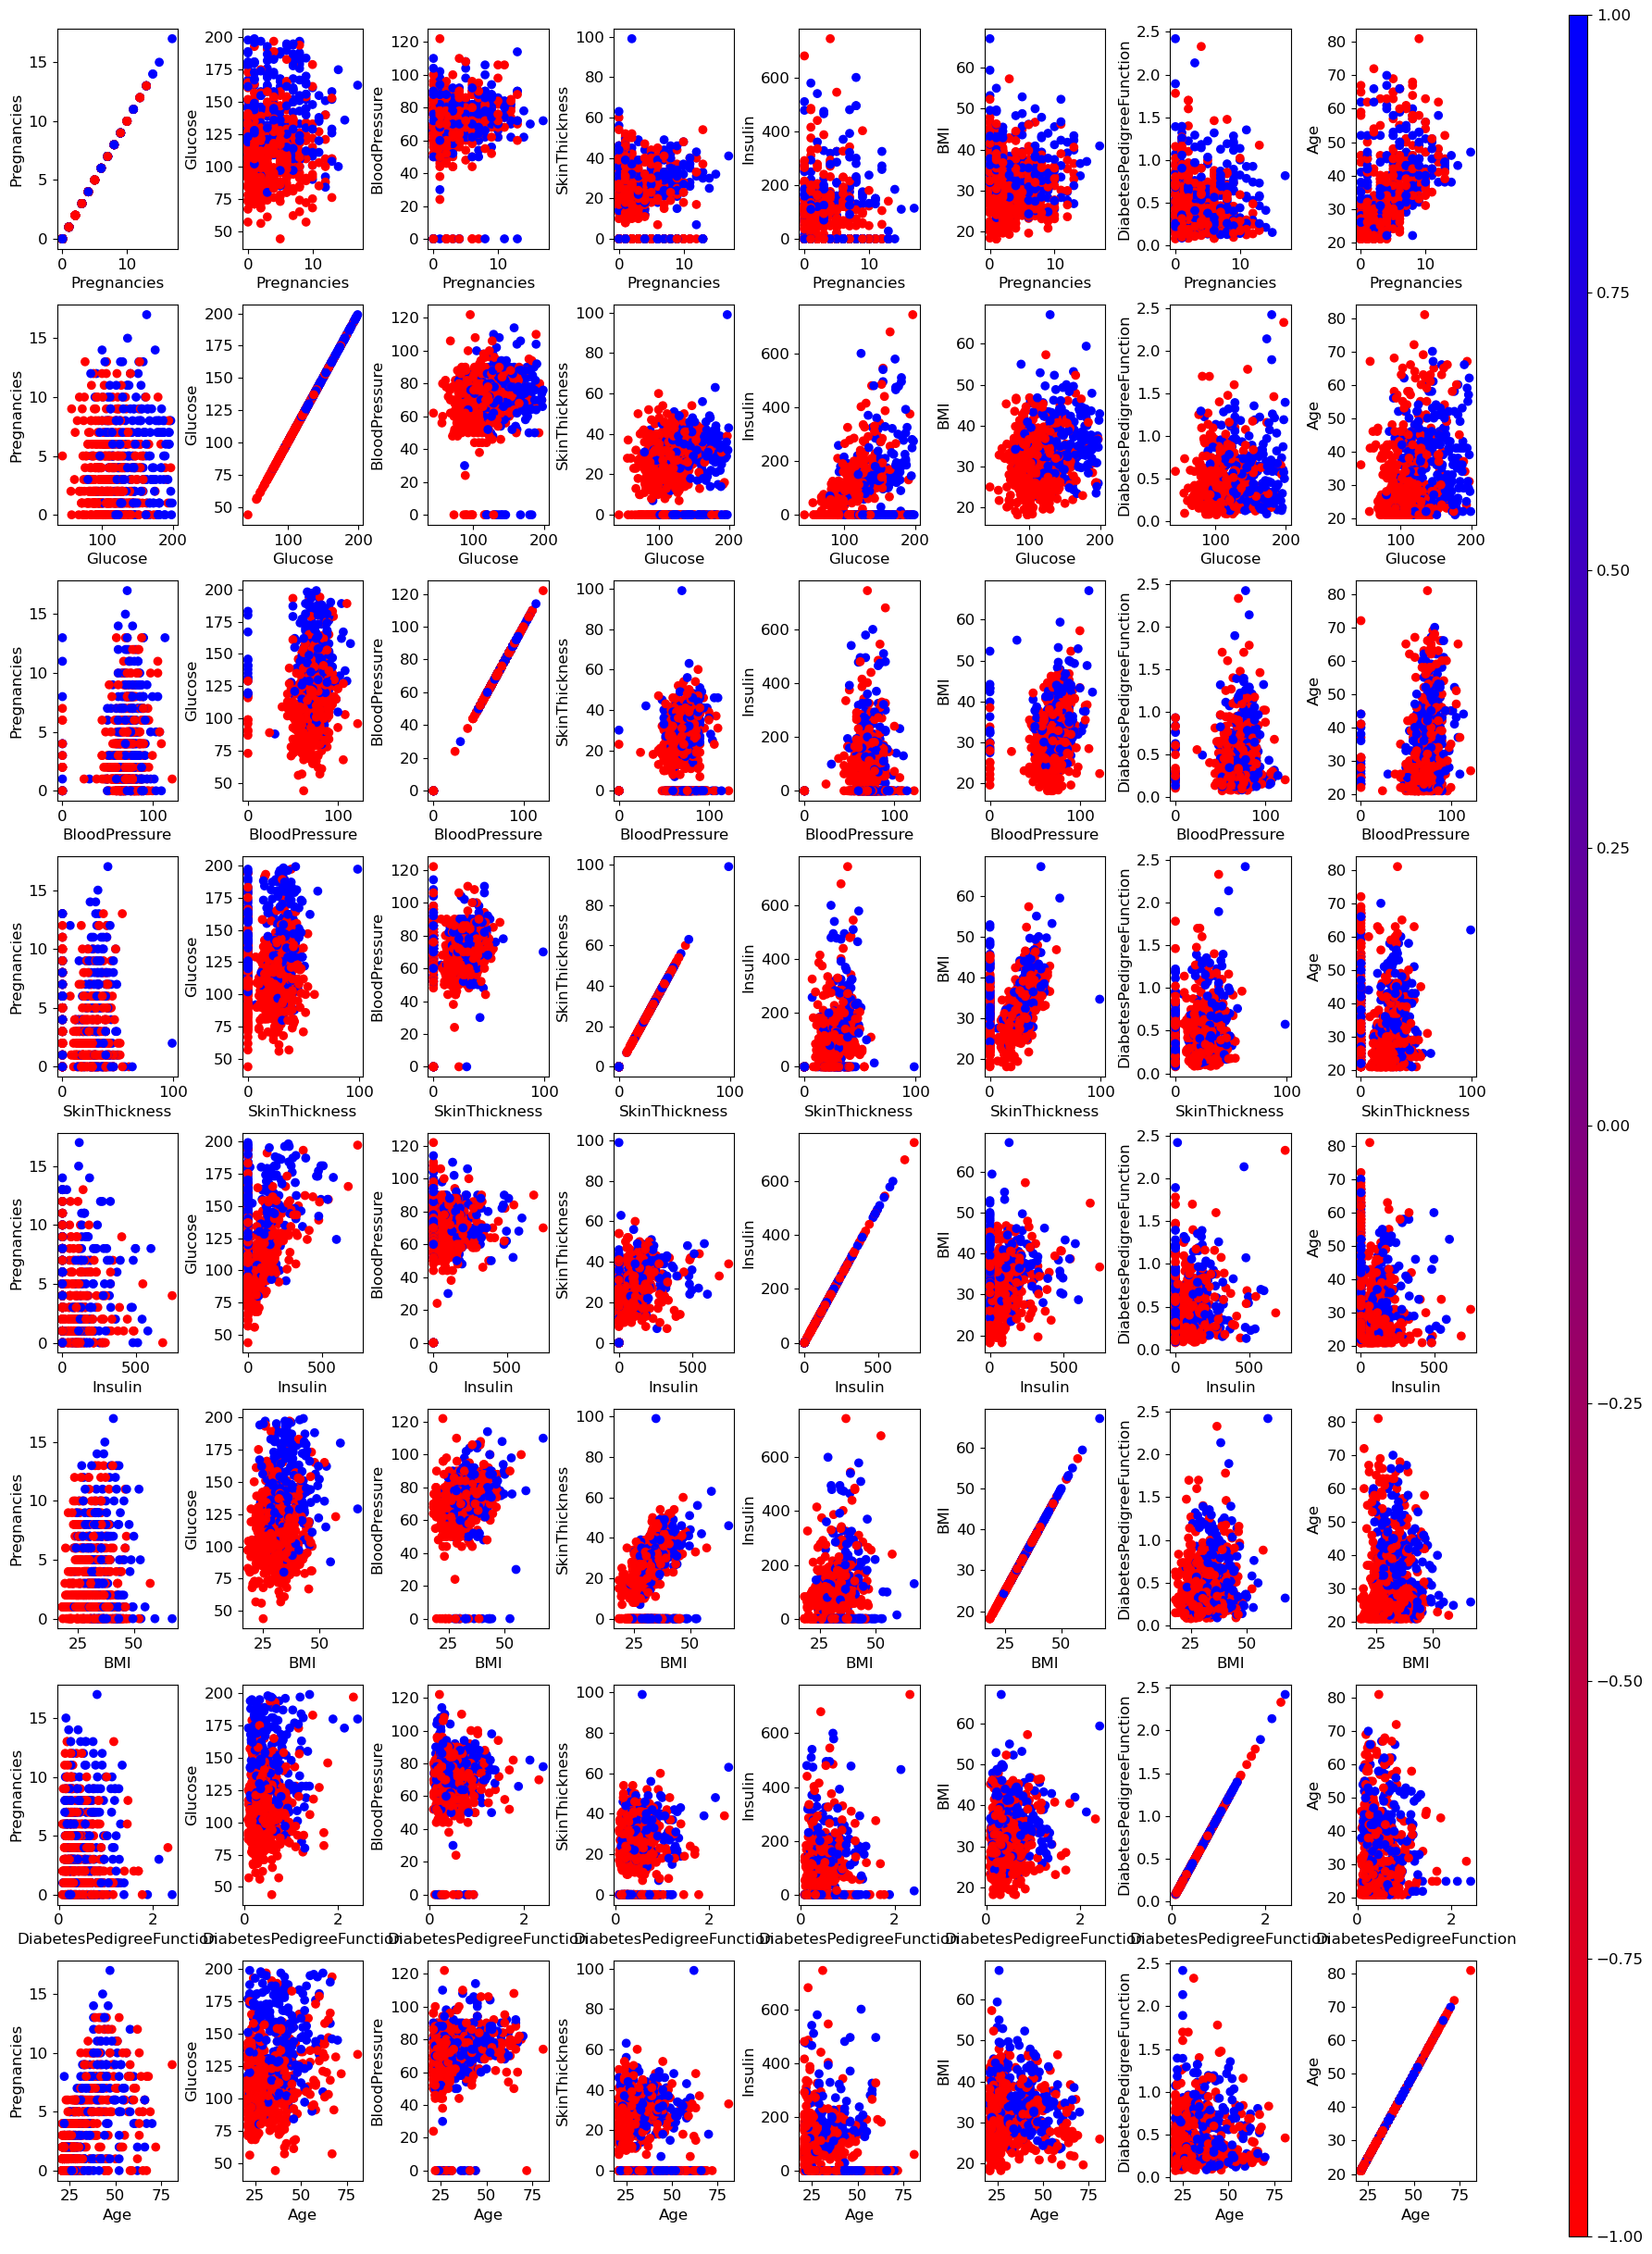

In [9]:
def pairplot(data, y, varsnames):
    data = data
    size = data.shape[1]
    fig, axs = plt.subplots(size, size, figsize=(20, size * 3))
    for i in range(size):
        for j in range(size):
            # if i != j:
            im = axs[i][j].scatter(data[:, i], data[:, j], c=y, cmap=cmap)
            axs[i][j].set_xlabel(varsnames[i])
            axs[i][j].set_ylabel(varsnames[j])
            # else:
            #     axs[i][j].plot(
            #         y[:700].reshape(10, 70).sum(0),
            #     )
            #     axs[i][j].set_title("frequency of " + str(varsnames[j]))

    plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0, 0.01, 1])
    fig.colorbar(im, cax=cbar_ax)

    plt.show()


pairplot(pima_x, pima_y, pima_vars)

• What are the variables that seem to help predict the class? Do those variable make sense from a
medical perspective ?

- we notice that when glucose is so high, the patient has probably diabetes, which could be confirmed by the medical perspective. Because the glucose is highly correlated with the risk of getting diabetes
- the high BMI is a factor of diabetes, and from a medical perspective "Obesity was linked with increased rates of diabetes between 2.5 and 5 times higher than people of normal weight,"
-same for the insuline

#### Split the data in training/test by keeping n = 300 samples for training/validation and the remaining for test.

In [10]:
pima_xt, pima_xTest = pima_x[:300], pima_x[300:]
pima_yt, pima_yTest = pima_y[:300], pima_y[300:]

#### Do the feature have similar variances/scaling? Is that a problem?

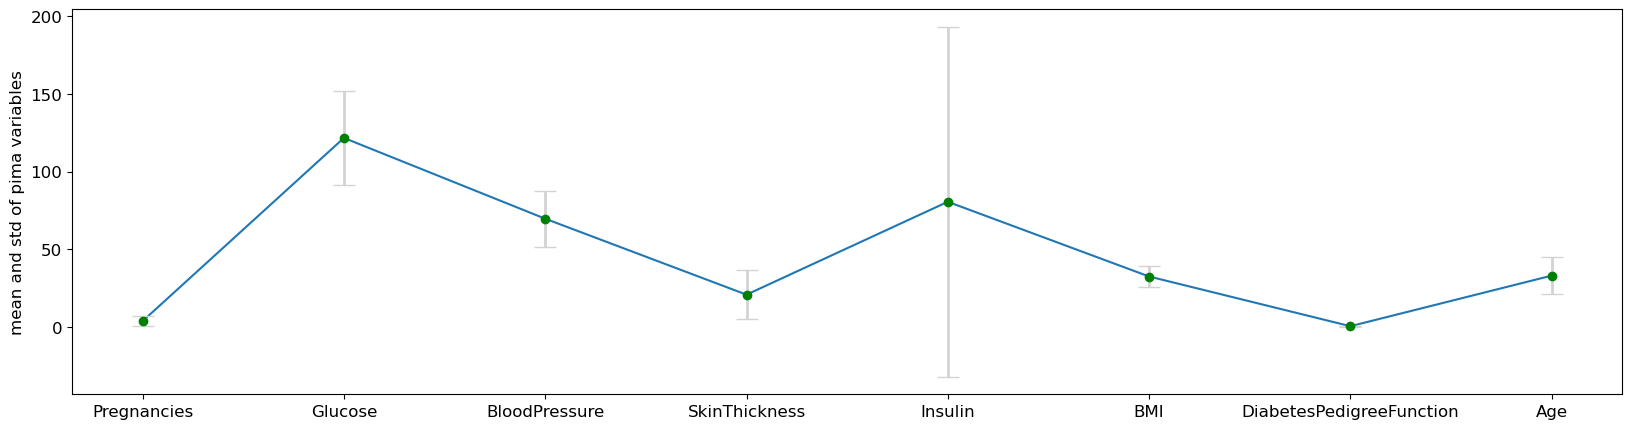

In [11]:
plt.figure()
plt.plot(pima_vars, pima_x.mean(0))
plt.errorbar(
    pima_vars, pima_x.mean(0), pima_x.std(0), fmt="o", color="green", ecolor="lightgray", elinewidth=2, capsize=8
)
plt.ylabel("mean and std of pima variables");

we notice that the variance of variables is very different, indeed some variables has high variance like Insulin however others like DiabetesPedigreeFuncyion and Pregnancies have low variance.

we notice that the pregnancies has a mean of 3.7 and a std of 3.3, which means that 75% of the population has between 0.4 and 6 children 
moreover, the age is has a mean of 33 years old with std 11.66 which represent perfectly a population older strictly than 21 years
however Insulin appears to have a higher variance and the data is spread around the mean

#### • Apply a standardization to the training and test data (StandardScaler).

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(pima_x);

In [13]:
pima_xt_s, pima_xTest_s = scaler.transform(pima_xt), scaler.transform(pima_xTest)

## Bayesian decision and linear classification

##### Train a Linear Discriminant Analysis (LDA) classifier with the default parameters, compute its accu-racy and AUC on the test data (LinearDiscriminantAnalysis,roc_auc_score). Note that in order to compute the AUC you will need to compute the score with est.predict_proba and keep the secondolumn (probability of the class 1).

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

pima_performances = dict()
LDA = LinearDiscriminantAnalysis(solver="lsqr")
LDA.fit(pima_xt_s, pima_yt);

In [15]:
from sklearn.metrics import roc_auc_score

pima_performances["LDA"] = {
    "accuracy": LDA.score(pima_xTest_s, pima_yTest),
    "auc": roc_auc_score(pima_yTest, LDA.predict_proba(pima_xTest_s)[:, 1]),
    "train_acc": LDA.score(pima_xt_s, pima_yt),
}

In [16]:
display(HTML(f"the <b>roc_auc score</b> with the <i>basic LDA</i> is  {pima_performances['LDA']['auc']:.2f}"))

display(HTML(f"the <b>accuracy_score</b> with the <i>basic LDA</i> is  {pima_performances['LDA']['accuracy']:.2f}"))

#### Perform a cross validation GridSearchCV) for the parameters of the method (shrinkage). Does the validation leads to better performance? What is the optimal value for the parameter?

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid["shrinkage"] = np.arange(0, 1, 0.01)
# define search
search = GridSearchCV(LDA, grid, scoring="roc_auc", cv=cv, n_jobs=-1)
# perform the search
results = search.fit(pima_xt_s, pima_yt)
# summarize
print("Mean Accuracy: %.3f" % results.best_score_)
print("Config: %s" % results.best_params_)

Mean Accuracy: 0.816
Config: {'shrinkage': 0.2}


In [18]:
LDA_best = results.best_estimator_
pima_performances["LDA_best"] = {
    "accuracy": LDA_best.score(pima_xTest_s, pima_yTest),
    "auc": roc_auc_score(pima_yTest, LDA_best.predict_proba(pima_xTest_s)[:, 1]),
    "train_acc": LDA_best.score(pima_xt_s, pima_yt),
}
display(HTML(f"the <b>roc_auc score</b> with the <i>best LDA model</i> is {pima_performances['LDA_best']['auc']:.2f}"))
display(
    HTML(
        f"the <b>accuracy_score</b> with the <i>best LDA model</i> is  {pima_performances['LDA_best']['accuracy']:.2f}"
    )
)

- yes we notice that the validation leads to better performance, because it avoids overfitting and iterates over grid values to find the best configuration for the model

- the optimal value of the parametre shrinkage is 0.2 and it gives almost the same performance which is in our case 0.87 for roc_auc score, but the accuracy is impouved also 

##### Train a Quadratic Discriminant Analysis (QDA) classifier with the default parameters, compute its accuracy and AUC on the test data (QuadraticDiscriminantAnalysis). Is the performance better than LDA?

In [19]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

QDA = QuadraticDiscriminantAnalysis()
QDA.fit(pima_xt_s, pima_yt)
pima_performances["QDA"] = {
    "accuracy": QDA.score(pima_xTest_s, pima_yTest),
    "auc": roc_auc_score(pima_yTest, QDA.predict_proba(pima_xTest_s)[:, 1]),
    "train_acc": QDA.score(pima_xt_s, pima_yt),
}
display(
    HTML(
        f"the <b>roc_auc score</b> with the <i>basic QDA</i> is {pima_performances['QDA']['auc']:.2f},\
            and the accuracy is {pima_performances['QDA']['accuracy']:.2f}\
            so it's less than the <i>basic LDA</i> gives {pima_performances['LDA']['auc']:.2f}"
    )
)

##### Perform a cross validation for the parameters of the method (reg_param). Does the validation leads to better performance? What is the optimal value for the parameter.

In [20]:
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid["reg_param"] = np.arange(0, 0.8, 0.01)
# define search
search = GridSearchCV(QDA, grid, scoring="roc_auc", cv=cv, n_jobs=-1)
# perform the search
results = search.fit(pima_xt_s, pima_yt)
# summarize
print("Mean Accuracy: %.3f" % results.best_score_)
print("Config: %s" % results.best_params_)

Mean Accuracy: 0.811
Config: {'reg_param': 0.74}


In [21]:
QDA_best = results.best_estimator_
pima_performances["QDA_best"] = {
    "accuracy": QDA_best.score(pima_xTest_s, pima_yTest),
    "auc": roc_auc_score(pima_yTest, QDA_best.predict_proba(pima_xTest_s)[:, 1]),
    "train_acc": QDA_best.score(pima_xt_s, pima_yt),
}
display(
    HTML(
        f"the <b>roc_auc score</b> with the <i>best QDA model</i> is {pima_performances['QDA_best']['auc']:.2f} \
            and the accuracy is {pima_performances['QDA_best']['accuracy']:.2f}"
    )
)

- the optimal value of the parametre reg_pparam is 0.74 and it gives better performance which is in our case almost 0.86 for roc_auc score and a btter accuracy of 0.8

##### Train a Gaussian Naive Bayes (NB) classifier (GaussianNB). What is its performance with respect to QDA and LDA?

In [22]:
from sklearn.naive_bayes import GaussianNB

NB = GaussianNB()
NB.fit(pima_xt, pima_yt)
pima_performances["NB"] = {
    "accuracy": NB.score(pima_xTest_s, pima_yTest),
    "auc": roc_auc_score(pima_yTest, NB.predict_proba(pima_xTest_s)[:, 1]),
    "train_acc": NB.score(pima_xt_s, pima_yt),
}
display(
    HTML(
        f"the <b>roc_auc score</b> with the <i>basic NB</i> is {pima_performances['NB']['auc']:.2f}\
            and the accuracy is {pima_performances['NB']['accuracy']:.2f}\
            , so it's less than the <i>basic LDA</i> that gives {pima_performances['LDA']['auc']:.2f} \
                and greater than the <i>basic QDA</i> that gives {pima_performances['QDA']['auc']:.2f}"
    )
)

##### Train a Logistic regression classifier (LogisticRegression) with the default parameters. Compute its performance and compare it to the previous classifiers.

In [23]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression().fit(pima_xt, pima_yt)
pima_performances["LR"] = {
    "accuracy": LR.score(pima_xTest_s, pima_yTest),
    "auc": roc_auc_score(pima_yTest, LR.predict_proba(pima_xTest_s)[:, 1]),
    "train_acc": LR.score(pima_xt_s, pima_yt),
}
display(
    HTML(
        f"the <b>roc_auc score</b> with the <i>BASIC Logistic Regression model</i> is {pima_performances['LR']['auc']:.2f} \
            and the accuracy is {pima_performances['LR']['accuracy']:.2f}"
    )
)

In [24]:
LR.coef_

array([[ 1.06e-01,  2.06e-02, -2.21e-02, -1.27e-02, -1.13e-03,  4.60e-02,
         1.61e+00, -5.42e-03]])

In [25]:
def showPerform(performances):
    return {item: {elem: round(performances[item][elem], 2) for elem in performances[item]} for item in performances}


showPerform(pima_performances)

{'LDA': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.76},
 'LDA_best': {'accuracy': 0.81, 'auc': 0.87, 'train_acc': 0.77},
 'QDA': {'accuracy': 0.76, 'auc': 0.81, 'train_acc': 0.75},
 'QDA_best': {'accuracy': 0.8, 'auc': 0.86, 'train_acc': 0.76},
 'NB': {'accuracy': 0.63, 'auc': 0.5, 'train_acc': 0.61},
 'LR': {'accuracy': 0.68, 'auc': 0.59, 'train_acc': 0.65}}

- we notice that LR isn't better than LDA AND QDA 

##### Perform a a cross validation for the parameters of the model (C) by setting the penalization to L1. Is the model sparse? What variables were removed from the model? Is the classifier performing well?

In [26]:
LR_L1 = LogisticRegression(penalty="l1", solver="liblinear")
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid["C"] = np.logspace(-10, 5, 100)
# define search
search = GridSearchCV(LR_L1, grid, scoring="roc_auc", cv=cv, n_jobs=-1)
# perform the search
results = search.fit(pima_xt_s, pima_yt)
# summarize
print("Mean Accuracy: %.3f" % results.best_score_)
print("Config: %s" % results.best_params_)

Mean Accuracy: 0.814
Config: {'C': 0.3511191734215127}


In [27]:
LR_best = results.best_estimator_
pima_performances["LR_best"] = {
    "accuracy": LR_best.score(pima_xTest_s, pima_yTest),
    "auc": roc_auc_score(pima_yTest, LR_best.predict_proba(pima_xTest_s)[:, 1]),
    "train_acc": LR_best.score(pima_xt_s, pima_yt),
}

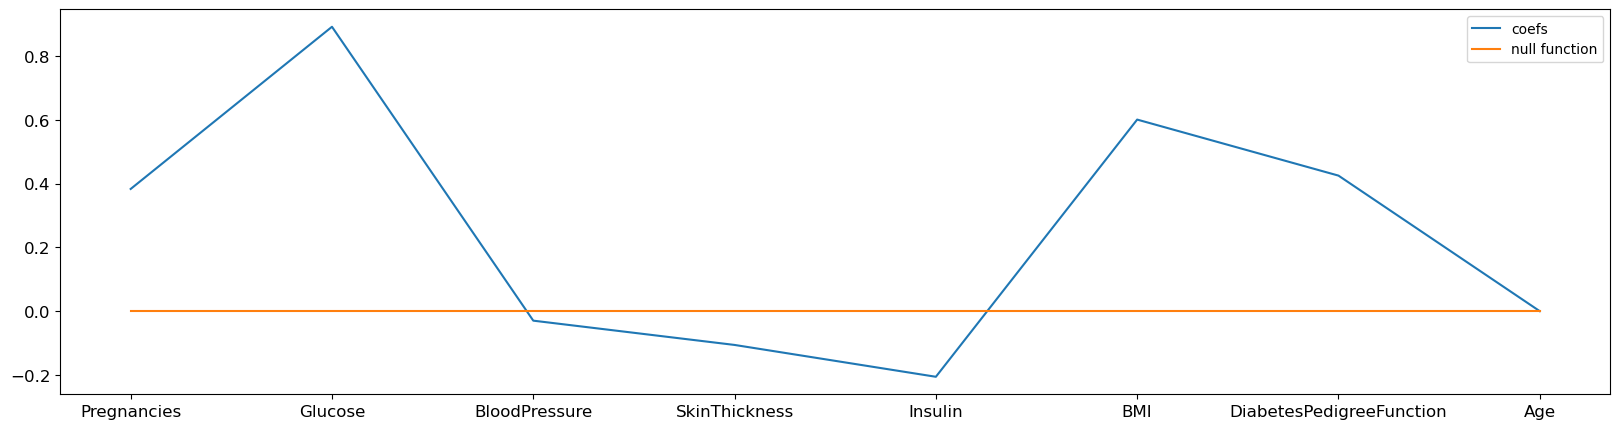

In [28]:
plt.plot(pima_vars, LR_best.coef_.flatten(), label="coefs")
plt.plot(pima_vars, np.array([0] * 8), label="null function")
plt.legend();

- we notice that the model is sparse because the last feature ( age ) has a coef of 0 and also the BloodPressure isn't very significant in the probleme, howver glicose and BMI have a big influence

In [29]:
showPerform(pima_performances)

{'LDA': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.76},
 'LDA_best': {'accuracy': 0.81, 'auc': 0.87, 'train_acc': 0.77},
 'QDA': {'accuracy': 0.76, 'auc': 0.81, 'train_acc': 0.75},
 'QDA_best': {'accuracy': 0.8, 'auc': 0.86, 'train_acc': 0.76},
 'NB': {'accuracy': 0.63, 'auc': 0.5, 'train_acc': 0.61},
 'LR': {'accuracy': 0.68, 'auc': 0.59, 'train_acc': 0.65},
 'LR_best': {'accuracy': 0.8, 'auc': 0.87, 'train_acc': 0.77}}

- we notice that the classifier has almost the larget accuracy and auc_score which means that it performs well

##### What is the best decision method so far? Is the best model linear (LAD,LR) on quadratic (QDA,NB)?

- we notice that the higher values of bhoth accuracy and auc are for Linear regression and Linear discriment which allow us to conclude that the problem is probably linear 

##### Interpret the weight for a good linear model. What is the effect of each variable on the risk of diabetes? Does it make medical sense?

array([[ 0.38,  0.89, -0.03, -0.11, -0.21,  0.6 ,  0.43,  0.  ]])

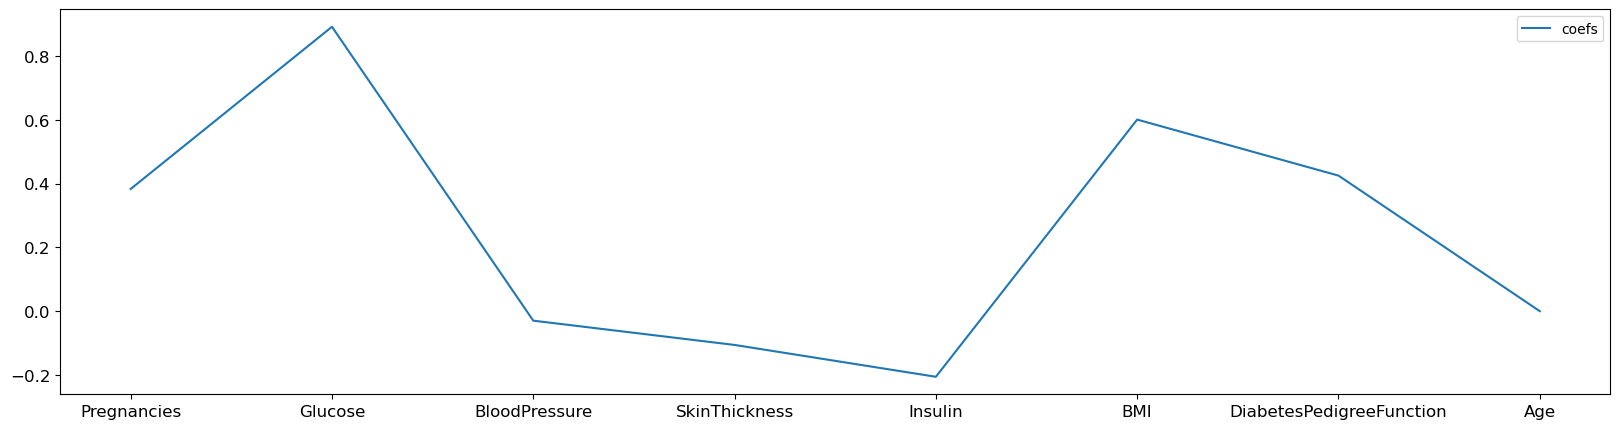

In [30]:
plt.plot(pima_vars, LR_best.coef_.flatten(), label="coefs")
plt.legend()
display(LR_best.coef_);

- we notice that clucose has the higher propotional impact on the diabetes risk, and from a 

Pima classifiation study of variables:
| The variable   |      the impact score      |  medical perspective |
|----------|:-------------:|------:|
|Pregnancies |  0.38 | Any woman can develop gestational diabetes during pregnancy, but you're at an increased risk |
| glucose |    0.89   |   A fasting blood sugar level of 99 mg/dL or lower is normal, 100 to 125 mg/dL indicates you have prediabetes, and 126 mg/dL or higher indicates you have diabetes. |
| Blood pressure | -0.03 |    “Over time, diabetes damages the small blood vessels in your body, causing the walls of the blood vessels to stiffen. This increases pressure, which leads to high blood pressure. which means the diabetes becomes before bloodpressure |
|SkinThickness |  -0.11| like blood pressure, skin thickness is just a possible result of diabetes, "Skin thickness is primarily determined by collagen content and is increased in insulin-dependent diabetes mellitus (IDDM)."  |
| Insulin|   -0.21   |   People with type 1 diabetes don't make enough insulin, and here we notice that less insuline impact the probability of getting diabetes by 0.21 |
| BMI | 0.6 |   he prevalence of diabetes mellitus and hypertension increased in an observable, linear fashion as BMI levels increased|
|DiabetesPedigreeFunction |  0.43| studies of twins have shown that genetics play a very strong role in the development of type 2 diabetes. |
| Age |    0   |   It occurs  in middle-aged and older adults, but it can also affect children. so age isn't a reliable cause |

## 2.3 Nonlinear methods
For the following non-linear classifiers, RandomForestClassifier, SVC, MLPClassifier,
GradientBoostingClassifier do the following:

##### • Fit the model with the default parameters and compute its prediction performance. Is it better than a linear estimator?

In [31]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

for name, model in {
    "RF": RandomForestClassifier(),
    "GD": GradientBoostingClassifier(),
    "MLP": MLPClassifier(),
    "SVC": SVC(probability=True),
}.items():
    fitted = model.fit(pima_xt_s, pima_yt)
    pima_performances[name] = {
        "accuracy": fitted.score(pima_xTest_s, pima_yTest),
        "auc": roc_auc_score(pima_yTest, fitted.predict_proba(pima_xTest_s)[:, 1]),
        "train_acc": fitted.score(pima_xt_s, pima_yt),
    }

In [32]:
showPerform(pima_performances)

{'LDA': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.76},
 'LDA_best': {'accuracy': 0.81, 'auc': 0.87, 'train_acc': 0.77},
 'QDA': {'accuracy': 0.76, 'auc': 0.81, 'train_acc': 0.75},
 'QDA_best': {'accuracy': 0.8, 'auc': 0.86, 'train_acc': 0.76},
 'NB': {'accuracy': 0.63, 'auc': 0.5, 'train_acc': 0.61},
 'LR': {'accuracy': 0.68, 'auc': 0.59, 'train_acc': 0.65},
 'LR_best': {'accuracy': 0.8, 'auc': 0.87, 'train_acc': 0.77},
 'RF': {'accuracy': 0.77, 'auc': 0.84, 'train_acc': 1.0},
 'GD': {'accuracy': 0.76, 'auc': 0.83, 'train_acc': 0.97},
 'MLP': {'accuracy': 0.78, 'auc': 0.85, 'train_acc': 0.82},
 'SVC': {'accuracy': 0.79, 'auc': 0.84, 'train_acc': 0.83}}

- we notice Headers, that the RF,GD,MLP,SVC models fails to estimate well the output, and they overfit (train accuracy almots 1 and accuracy on test 0.8), which imposes a fine tuning of parametres 

#####  Do a quick validation of some of the important parameters (manually or with sklearn classes). Can you find a better performance?

In [33]:
GD_params = {
    "loss": ["deviance"],
    "learning_rate": np.linspace(0.01, 0.2, 3),
    "max_depth": np.linspace(2, 10, 3).astype(int),
    "n_estimators": np.logspace(0, 3, 4).astype(int),
}
RF_params = {
    "bootstrap": [True, False],
    "max_depth": np.linspace(1, 100, 4).astype(int),
    "min_samples_leaf": [1, 4],
    "min_samples_split": [2, 5],
    "n_estimators": [200, 500, 1000],
}
MLP_params = {
    "hidden_layer_sizes": [(10, 30, 10), (20,)],
    "activation": ["tanh", "relu"],
    "alpha": [0.0001, 0.05],
    "learning_rate": ["adaptive"],
}
SVC_params = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01, 0.001], "kernel": ["rbf", "poly", "sigmoid"]}

In [34]:
bestModels = {}
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

In [35]:
for name, model_dict in {
    "RF_grid": {"model": RandomForestClassifier(), "params": RF_params},
    "GD_grid": {"model": GradientBoostingClassifier(), "params": GD_params},
    "MLP_grid": {"model": MLPClassifier(), "params": MLP_params},
    "SVC_grid": {"model": SVC(probability=True), "params": SVC_params},
}.items():

    print(name)
    # define search
    search = GridSearchCV(model_dict["model"], model_dict["params"], scoring="accuracy", cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(pima_xt_s, pima_yt)
    thisModel = results.best_estimator_
    bestModels[name] = thisModel
    pima_performances[name] = {
        "accuracy": thisModel.score(pima_xTest_s, pima_yTest),
        "auc": roc_auc_score(pima_yTest, thisModel.predict_proba(pima_xTest_s)[:, 1]),
        "train_acc": thisModel.score(pima_xt_s, pima_yt),
    }

RF_grid
GD_grid


/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v

MLP_grid


/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

SVC_grid


#####  Store the model and the accuracy for the best parameter configuration.

In [36]:
showPerform(pima_performances)

{'LDA': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.76},
 'LDA_best': {'accuracy': 0.81, 'auc': 0.87, 'train_acc': 0.77},
 'QDA': {'accuracy': 0.76, 'auc': 0.81, 'train_acc': 0.75},
 'QDA_best': {'accuracy': 0.8, 'auc': 0.86, 'train_acc': 0.76},
 'NB': {'accuracy': 0.63, 'auc': 0.5, 'train_acc': 0.61},
 'LR': {'accuracy': 0.68, 'auc': 0.59, 'train_acc': 0.65},
 'LR_best': {'accuracy': 0.8, 'auc': 0.87, 'train_acc': 0.77},
 'RF': {'accuracy': 0.77, 'auc': 0.84, 'train_acc': 1.0},
 'GD': {'accuracy': 0.76, 'auc': 0.83, 'train_acc': 0.97},
 'MLP': {'accuracy': 0.78, 'auc': 0.85, 'train_acc': 0.82},
 'SVC': {'accuracy': 0.79, 'auc': 0.84, 'train_acc': 0.83},
 'RF_grid': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.91},
 'GD_grid': {'accuracy': 0.77, 'auc': 0.85, 'train_acc': 0.77},
 'MLP_grid': {'accuracy': 0.8, 'auc': 0.86, 'train_acc': 0.78},
 'SVC_grid': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.8}}

- we notice that the models with cross validation are more stable, since the accuracy on training set is close to the accuracy on test set which means that those models are no more overfitted.
- the largest difference between train_acc and test_acc is for gradient boosting , which is already known for fast overfitting.

## 2.4 Comparison and interpretation

##### Collect the test pima_performances for all methods investigated above in a table (in a dataframe and printing it for instance). Which methods work the best in practice?

In [37]:
showPerform(pima_performances)

{'LDA': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.76},
 'LDA_best': {'accuracy': 0.81, 'auc': 0.87, 'train_acc': 0.77},
 'QDA': {'accuracy': 0.76, 'auc': 0.81, 'train_acc': 0.75},
 'QDA_best': {'accuracy': 0.8, 'auc': 0.86, 'train_acc': 0.76},
 'NB': {'accuracy': 0.63, 'auc': 0.5, 'train_acc': 0.61},
 'LR': {'accuracy': 0.68, 'auc': 0.59, 'train_acc': 0.65},
 'LR_best': {'accuracy': 0.8, 'auc': 0.87, 'train_acc': 0.77},
 'RF': {'accuracy': 0.77, 'auc': 0.84, 'train_acc': 1.0},
 'GD': {'accuracy': 0.76, 'auc': 0.83, 'train_acc': 0.97},
 'MLP': {'accuracy': 0.78, 'auc': 0.85, 'train_acc': 0.82},
 'SVC': {'accuracy': 0.79, 'auc': 0.84, 'train_acc': 0.83},
 'RF_grid': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.91},
 'GD_grid': {'accuracy': 0.77, 'auc': 0.85, 'train_acc': 0.77},
 'MLP_grid': {'accuracy': 0.8, 'auc': 0.86, 'train_acc': 0.78},
 'SVC_grid': {'accuracy': 0.79, 'auc': 0.86, 'train_acc': 0.8}}

- in practive both LDA and MLP gave the same results and the best

##### Which model is best from a medical/practical perspective? Do we need non-linearity in this application?

- the best model in the practical perspective is logistic regression, because it's the most interpretable approach. moreover , linear models give almost the same accuracy of non linear models, so for simplicity reasons, we don't need the non-linearity in this application

##### For the best model, compute the confusion matrix for the test data. What is the false negative rate (FNR) (FN/(FN+TP)) for this classifier? Is it good for this kind of applications?


In [38]:
predict_proba = np.vectorize(lambda item, tresh: 1 if item > tresh else -1)

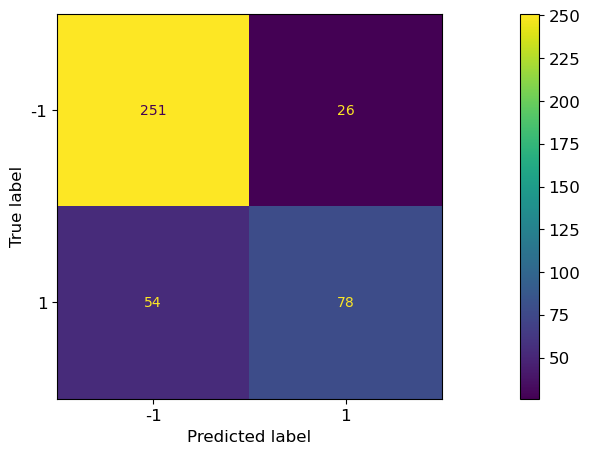

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_model = LR_best


def confusionMatrix(best_model, tresh):
    predictions = predict_proba(best_model.predict_proba(pima_xTest_s)[:, 1], tresh)
    cm = confusion_matrix(pima_yTest, predictions, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot()
    plt.show()


confusionMatrix(best_model, 0.5)


- the FNR is $\frac{64}{64+68}$ which is 48.48%
- this rate isn't good for this application, because many diabetes people will be considered as non sick people, and then their health will be worse over time , and this is harmful.
- so we can tolerate to tell a non sick person that he had diabetes instead of telling a diabetes person that he's fine.

##### Since a false negative can have an important medical impact, propose a new threshold for the predicted score that leads to a FNR of less that 10% (this can be done by changing manually the value of the intercept_ in the trained classifier).

In [40]:
def computeFNR(true, proba, threshold):
    cm = confusion_matrix(true, predict_proba(proba, threshold))
    return cm[1, 0] / (cm[1, 0] + cm[1, 1])

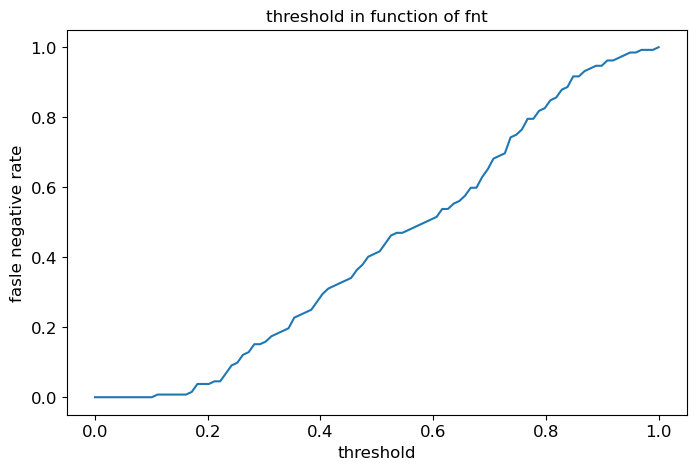

In [41]:
# Import necessary modules
from sklearn.metrics import roc_curve

from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap


tresh = 0.5
# Compute predicted probabilities: y_pred_prob
y_pred_prob = best_model.predict_proba(pima_xTest_s)[:, 1]


def plot_my_roc(true, proba):
    # Generate ROC curve values: fpr, tpr, thresholds
    thresholds = np.linspace(0, 1, 100)

    fnr = [computeFNR(true, proba, threshold) for threshold in thresholds]
    # tnr, fnr, thresholds = roc_curve(true, proba, pos_label=-1)
    plt.figure(figsize=(8, 5))
    plt.plot(thresholds, fnr)
    plt.xlabel("threshold")
    plt.ylabel("fasle negative rate")
    plt.title("threshold in function of fnt")
    plt.show()


plot_my_roc(pima_yTest, y_pred_prob)

- we will benifit of ROC curve to lead us to choose to choose the best threshold, since it gives us an easy visualization to see the impact of threshold values on the FNR

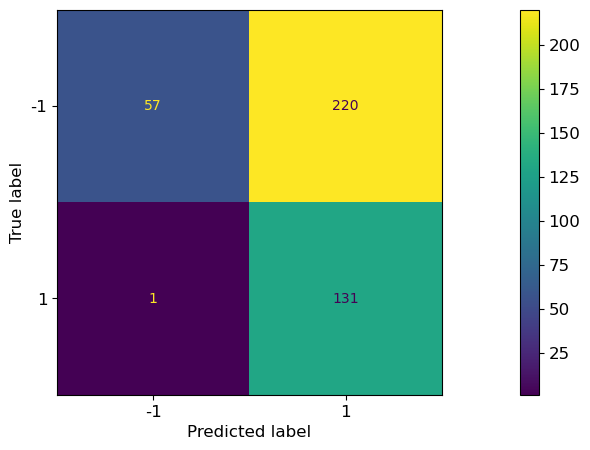

In [42]:
confusionMatrix(best_model, 0.12)

- we notice that for 0.12 as a threshold,we can tell a patient that he hasn't diabetes with 100 % of confidence. 
- if we detect that a person has diabetes, so we aren't very sure, because the probability of having actually diabetes is : $\frac{132}{132+215}$ which is only 38%. which means that 38% he has diabetes even if the model says he has diabetes.

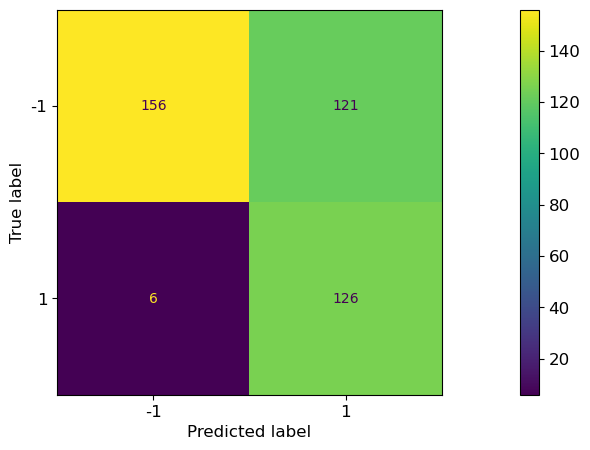

In [43]:
confusionMatrix(best_model, 0.22)

- with a threshold of 0.22 , we notice that the False negative rate is 9.8% less than 10%, which mean if we tell a person that he hasn't diabetes we have a probability of less than 10% to make a mistake

# 3 Predicting Classes on the Digits dataset
You already used this dataset in a previous session so it is assumed that you already know its properties.
The data is already split in training/test sets.

## 3.1 Evaluate the different supervised methods
For at least the following classifiers LinearDiscriminantAnalysis,LogisticRegression,SVC,MLPClassifier
do the following.

##### Fit the model with the default parameters and compute its prediction performance (accuracy on test data).

In [44]:
digits_performances = dict()

In [45]:
for name, model in {
    "RF": RandomForestClassifier(),
    "GD": GradientBoostingClassifier(),
    "MLP": MLPClassifier(),
    "SVC": SVC(probability=True),
}.items():
    fitted = model.fit(digits_xt, digits_yt)
    digits_performances[name] = {
        "accuracy": fitted.score(digits_x, digits_y),
        "train_acc": fitted.score(digits_xt, digits_yt),
    }

In [46]:
showPerform(digits_performances)

{'RF': {'accuracy': 0.98, 'train_acc': 1.0},
 'GD': {'accuracy': 0.97, 'train_acc': 1.0},
 'MLP': {'accuracy': 0.98, 'train_acc': 1.0},
 'SVC': {'accuracy': 0.99, 'train_acc': 1.0}}

##### Do a quick validation of some of the important parameters (manually or with sklearn classes) to get a better performance if possible.

In [47]:
GD_params = {
    "loss": ["deviance"],
    "n_estimators": np.logspace(0, 10, 2).astype(int),
}
RF_params = {
    "max_depth": np.linspace(1, 100, 2).astype(int),
    "n_estimators": [200, 1000],
}
MLP_params = {
    "alpha": [0.0001, 0.05],
    "learning_rate": ["adaptive"],
}
SVC_params = {"C": [0.1, 1, 10], "gamma": [1, 0.001]}


bestModels_digits = {}
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=2, random_state=1)

for name, model_dict in {
    "RF_grid": {"model": RandomForestClassifier(), "params": RF_params},
    "GD_grid": {"model": GradientBoostingClassifier(), "params": GD_params},
    "MLP_grid": {"model": MLPClassifier(), "params": MLP_params},
    "SVC_grid": {"model": SVC(probability=True), "params": SVC_params},
}.items():

    print(name)
    # define search
    search = GridSearchCV(model_dict["model"], model_dict["params"], scoring="accuracy", cv=cv, n_jobs=-1)
    # perform the search
    results = search.fit(digits_xt, digits_yt.ravel())
    thisModel = results.best_estimator_
    bestModels_digits[name] = thisModel
    digits_performances[name] = {
        "accuracy": thisModel.score(digits_x, digits_y),
        "train_acc": thisModel.score(digits_x, digits_y),
    }

RF_grid
GD_grid


/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(
/home/zechchair/anaconda3/envs/graph/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v

MLP_grid
SVC_grid


In [48]:
showPerform(digits_performances)

{'RF': {'accuracy': 0.98, 'train_acc': 1.0},
 'GD': {'accuracy': 0.97, 'train_acc': 1.0},
 'MLP': {'accuracy': 0.98, 'train_acc': 1.0},
 'SVC': {'accuracy': 0.99, 'train_acc': 1.0},
 'RF_grid': {'accuracy': 0.98, 'train_acc': 0.98},
 'GD_grid': {'accuracy': 0.9, 'train_acc': 0.9},
 'MLP_grid': {'accuracy': 0.98, 'train_acc': 0.98},
 'SVC_grid': {'accuracy': 0.98, 'train_acc': 0.98}}

- using the cross validation we avoided the overfitting , as the dict above shows

##### Store the model and the accuracy for the best parameter configuration.

In [49]:
bestModels_digits

{'RF_grid': RandomForestClassifier(max_depth=100, n_estimators=200),
 'GD_grid': GradientBoostingClassifier(loss='deviance', n_estimators=1),
 'MLP_grid': MLPClassifier(learning_rate='adaptive'),
 'SVC_grid': SVC(C=10, gamma=0.001, probability=True)}

## 3.2 Interpreting the classifier

##### Compare the performances of the different methods (with different metrics). Which model is the best on test data?

In [50]:
from sklearn.metrics import classification_report

for name, model in bestModels_digits.items():
    display(HTML("<h4>" + name + "</h4>"))
    print(classification_report(digits_y, model.predict(digits_x)))

              precision    recall  f1-score   support

           1       0.99      0.97      0.98      1000
           7       0.98      0.98      0.98      1000
           8       0.97      0.98      0.97      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



              precision    recall  f1-score   support

           1       0.93      0.86      0.89      1000
           7       0.92      0.95      0.94      1000
           8       0.85      0.88      0.86      1000

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



              precision    recall  f1-score   support

           1       0.98      0.98      0.98      1000
           7       0.98      0.99      0.99      1000
           8       0.98      0.97      0.97      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



              precision    recall  f1-score   support

           1       0.97      0.98      0.98      1000
           7       0.98      0.99      0.99      1000
           8       0.98      0.96      0.97      1000

    accuracy                           0.98      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.98      0.98      0.98      3000



- we notice that almost all the models performs good , however the gradient descent isn't as good as the others, but enough
- we will choose the random forest model because it avoids overfitting by construction

#####  Select the best classifier from the previous section and use it to predict labels on the test data.

In [51]:
best_model_digits = bestModels_digits["RF_grid"]

In [52]:
digits_predictions = best_model_digits.predict(digits_x)

#####  Compute the confusion matrix and interpret the errors made by the classifier. What is the class that is the most difficult to recognize? Are there somme classes that are harder to discriminate?

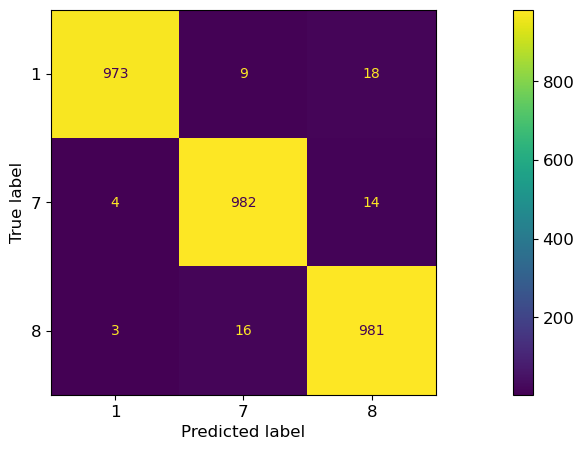

In [95]:
def confusionMatrix(best_model, digits_x, digits_y):
    predictions = best_model.predict(digits_x)
    cm = confusion_matrix(digits_y, predictions, labels=best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
    disp.plot()
    plt.show()


confusionMatrix(best_model_digits, digits_x, digits_y)

- the number 1 is the most difficult to recognize, because sometimes it looks like 7 and if it's not well written then it looks like 8
- also the number 8 is hard to recognize, because sometimes it looks like 7 when it's thin 

we can also suggest an approach to estimate the best threshold which gives a good precision and recall

In [54]:
def computeRecall(true, proba, threshold):
    cm = confusion_matrix(true, predict_proba(proba, threshold))
    return cm[1, 1] / (cm[1, 0] + cm[1, 1])


def computePrecision(true, proba, threshold):
    cm = confusion_matrix(true, predict_proba(proba, threshold))
    return cm[1, 1] / (cm[0, 1] + cm[1, 1])

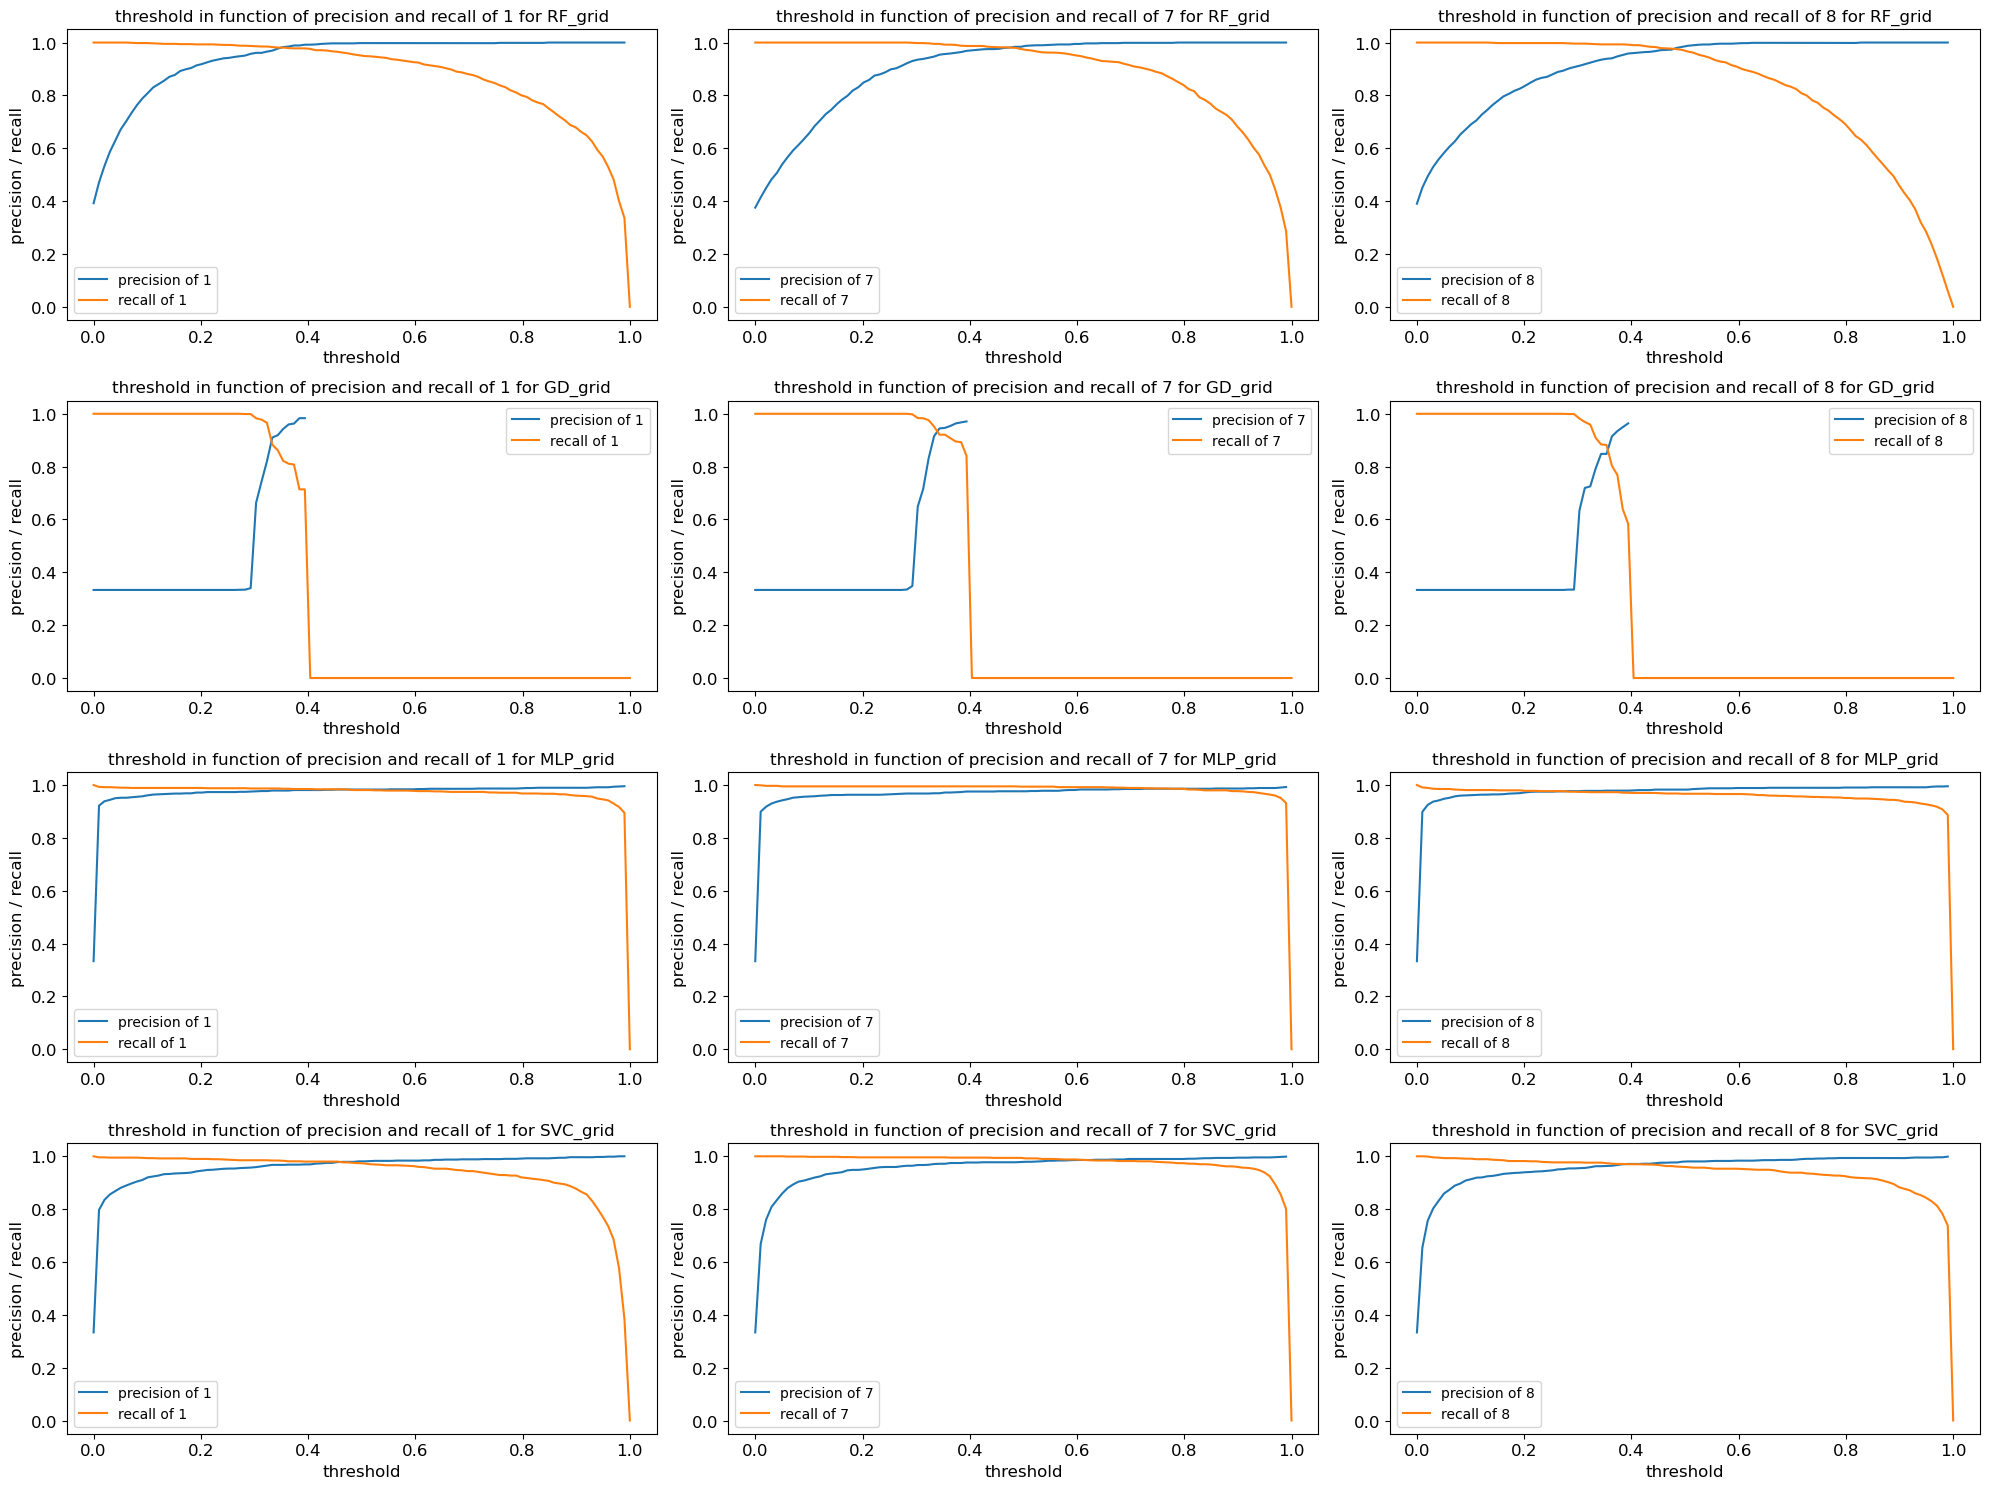

In [55]:
# display(HTML("<h6>ONE OVER REST precision/recall curves</h6>"))

# Plots the Probability Distributions and the ROC Curves One vs Rest
fig, axs = plt.subplots(4, 3, figsize=(20, 15))
j = 0
for name, model in bestModels_digits.items():

    fitted = model
    roc_auc_ovr = {}
    classes = fitted.classes_
    y_proba = fitted.predict_proba(digits_x)
    for i in range(len(classes)):
        # Gets the class
        c = classes[i]

        # Prepares an auxiliar dataframe to help with the plots
        df_aux = digits_x
        true = [1 if y == c else -1 for y in digits_y]

        proba = y_proba[:, i]
        # Calculates the ROC Coordinates and plots the ROC Curves
        thresholds = np.linspace(0, 1, 100)

        recall = [computeRecall(true, proba, threshold) for threshold in thresholds]
        precision = [computePrecision(true, proba, threshold) for threshold in thresholds]

        axs[j][i].plot(thresholds, precision, label="precision of " + str(c))
        axs[j][i].plot(thresholds, recall, label="recall of " + str(c))
        axs[j][i].set_xlabel("threshold")
        axs[j][i].set_ylabel("precision / recall")
        axs[j][i].set_title("threshold in function of precision and recall of " + str(c) + " for " + str(name))
        axs[j][i].legend()

        # Calculates the ROC AUC OvR
        roc_auc_ovr[c] = roc_auc_score(true, proba)
    digits_performances[name] = {
        "accuracy": fitted.score(digits_x, digits_y),
        "auc": roc_auc_ovr,
        "train_acc": fitted.score(digits_xt, digits_yt),
    }
    j += 1
plt.tight_layout()

- this approach helps to estimate the best threshold based on desired precision /recall,
- we can see clearly how gradient boosting fails to make good prediction
- moreover we observe that MLP had a curve better than Random forest and explain better the data
For example for random forest model that we adopted
- we notice that we have high precision and recall for threshold between 0.4 and 0.5 which maximize the accuracy for all classes
- we can explain why the class ( 1 ) is difficult to detect, by the fact that the best threshold for maximizing both the precision and recall in the random forest model is 0.35 however, model.predict use by default 0.5 , which is close to the threshold which maximize the precision an recall of the other classes


##### Plot some of the sample that are miss-classified. Are they difficult to recognize ? Why did the classifier fail to recognize them?

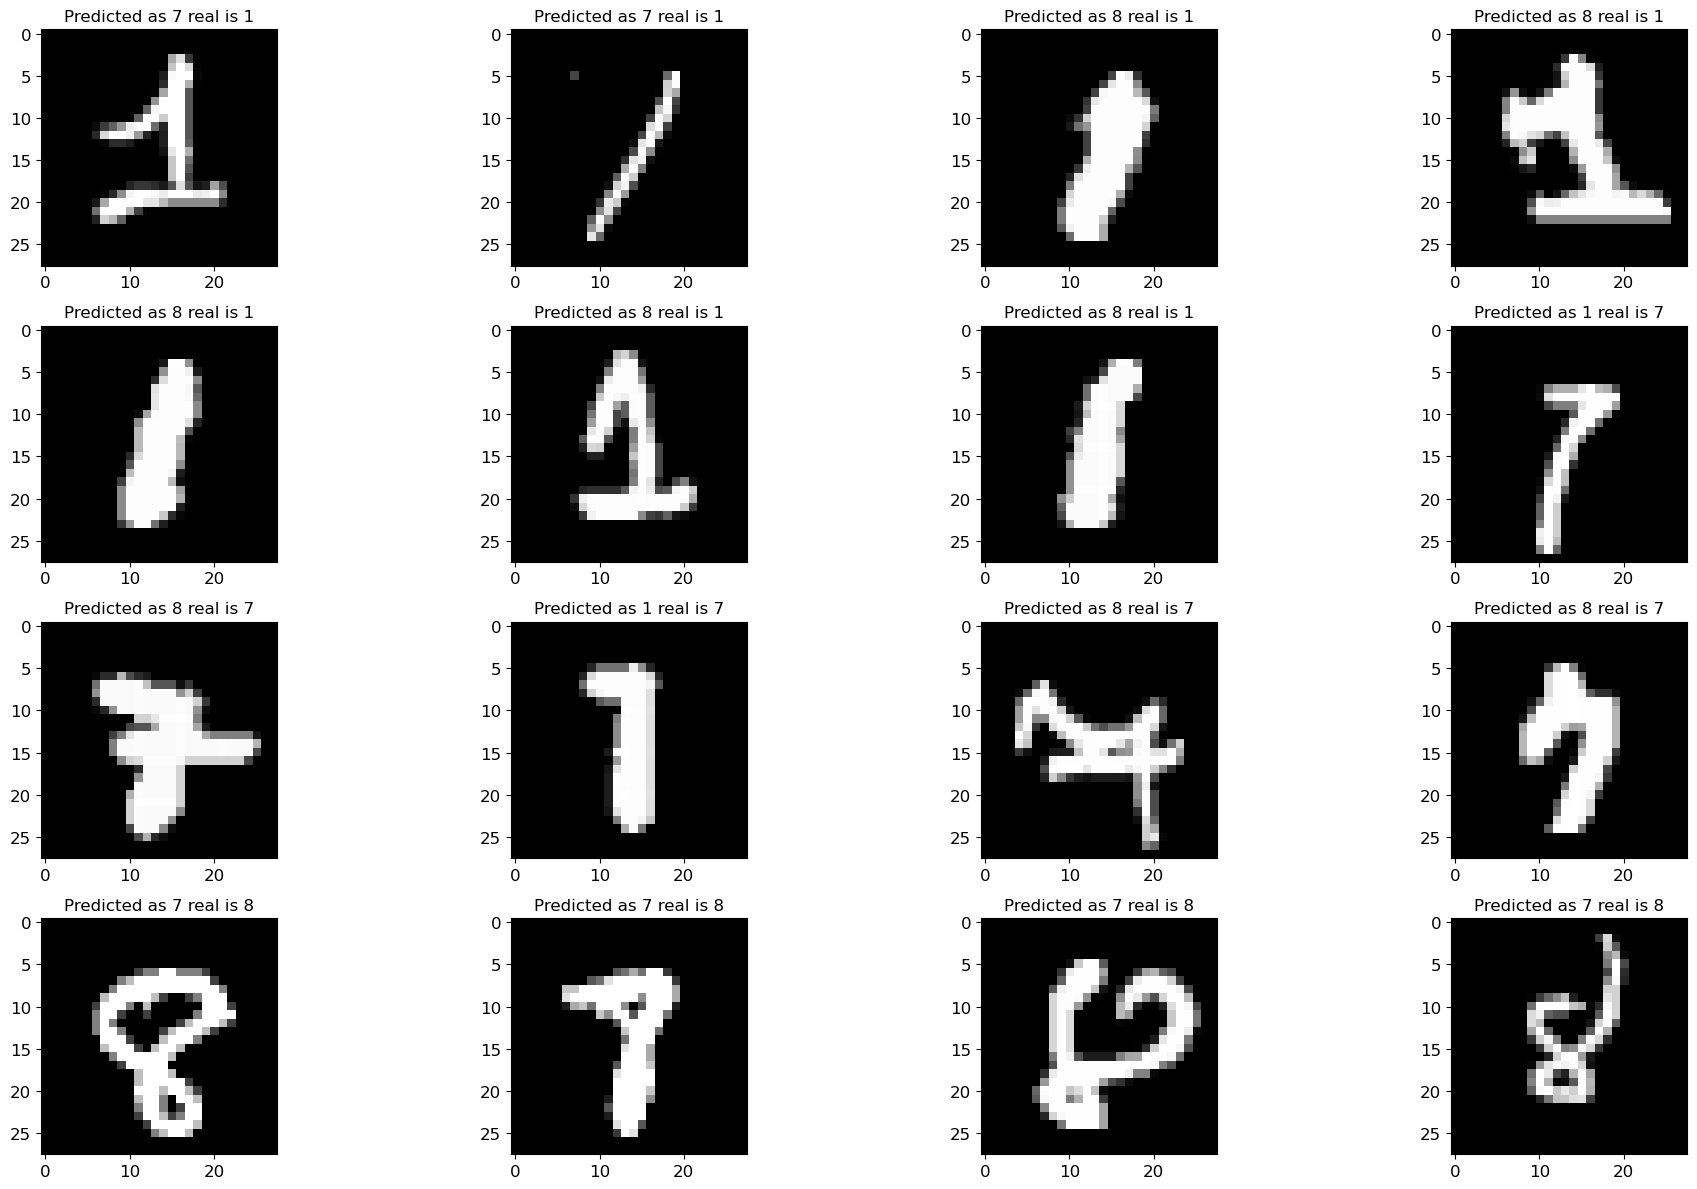

In [56]:
failed_digits, classes, actual = (
    digits_x[digits_predictions != digits_y.ravel()],
    digits_predictions[digits_predictions != digits_y.ravel()].ravel(),
    digits_y[digits_predictions != digits_y.ravel()].ravel(),
)
title = [str(pred) + " real is " + str(real) for pred, real in zip(classes, actual)]
plot_digits(failed_digits[::4], "Predicted as ", title[::4])

- we notice that the records where the model fail, are either very difficult to distinguish even
- sometimes the model predict an image good, even if it's mislabeled in the original data set

##### Pick a well classified sample and create 1000 noisy samples of it by adding gaussian noise (np.random.randn). Pick a level of noise that allows you to still distinguish clearly the class. Compute the accuracyof the classifier on those 1000 noisy samples. If the accuracy is 1, increase the noise level or choose another well classified sample.

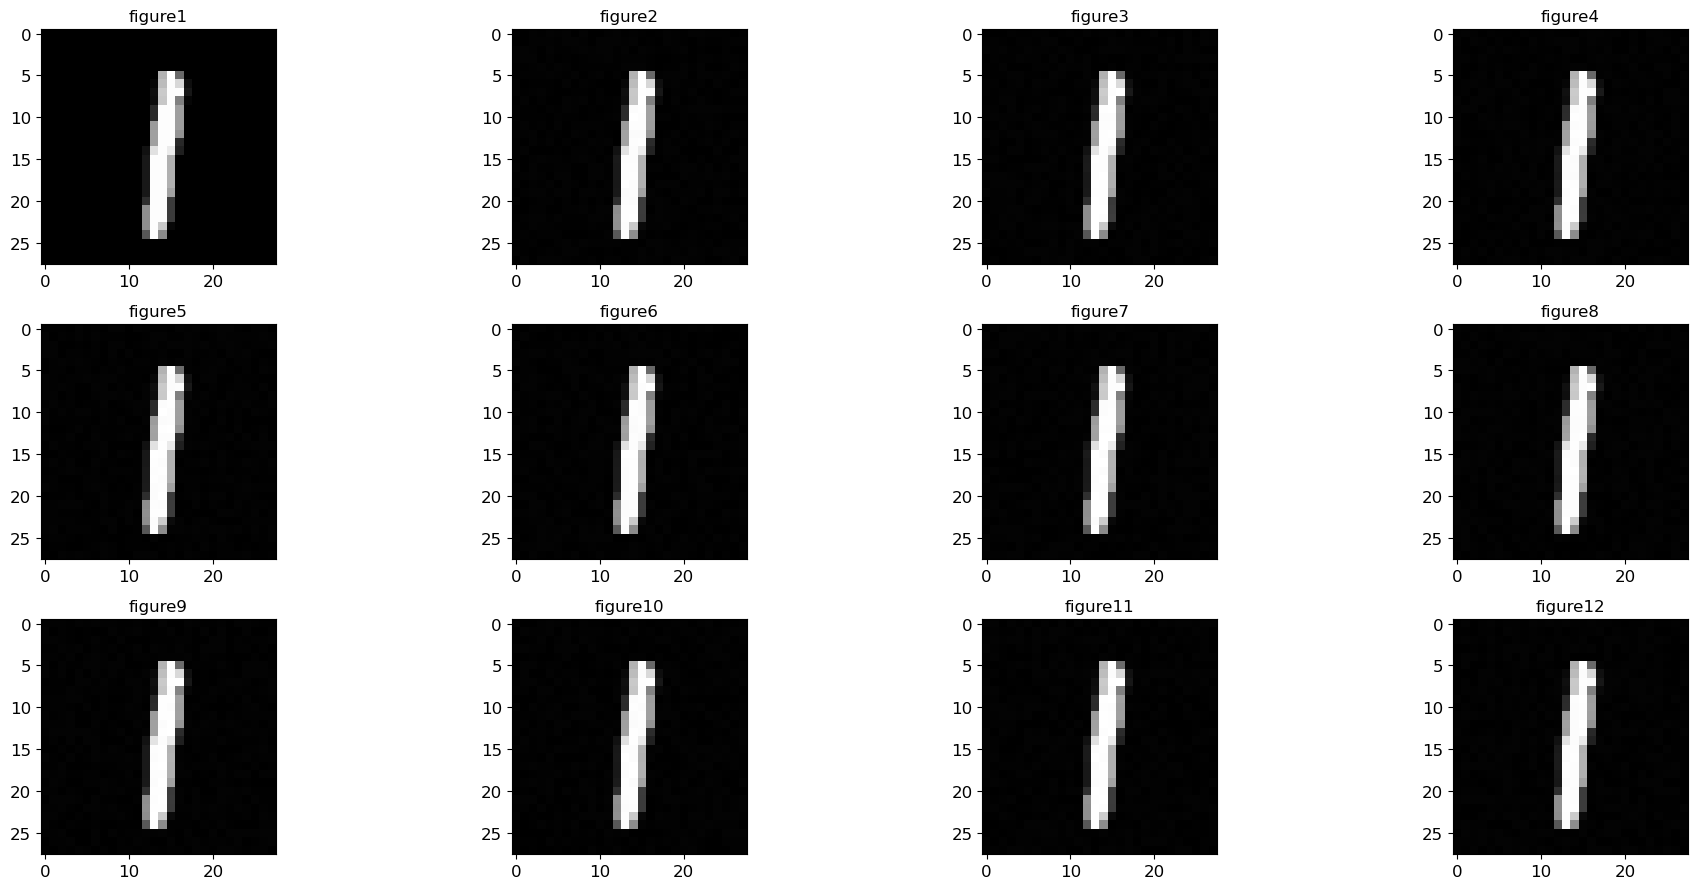

In [252]:
select = 5
well_classified = digits_x[digits_predictions == digits_y.ravel()][select]
class_of_well_classified = digits_y[digits_predictions == digits_y.ravel()].ravel()[select]
well_classified_noise = well_classified + np.random.rand(1000, len(well_classified)) / 65
prediction_with_noise = best_model_digits.predict(well_classified_noise)
plot_digits(
    np.concatenate((well_classified_noise, np.array([well_classified])), axis=0)[::-1][:12],
)

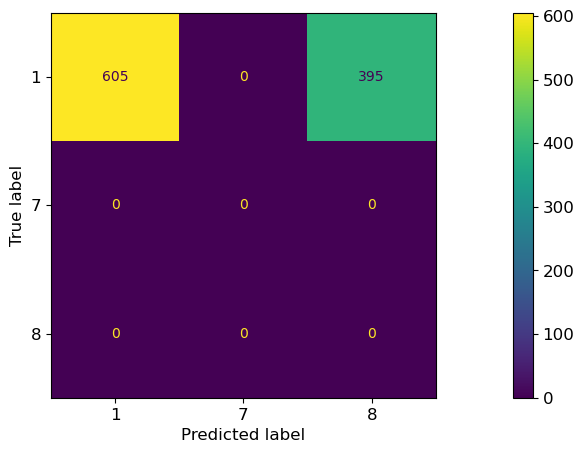

              precision    recall  f1-score   support

           1       1.00      0.60      0.75      1000
           8       0.00      0.00      0.00         0

    accuracy                           0.60      1000
   macro avg       0.50      0.30      0.38      1000
weighted avg       1.00      0.60      0.75      1000



In [253]:
confusionMatrix(best_model_digits, well_classified_noise, [class_of_well_classified] * len(well_classified_noise))
print(
    classification_report(
        [class_of_well_classified] * len(well_classified_noise), best_model_digits.predict(well_classified_noise)
    )
)

After trying many well classified numbers ( one , seven and eight), we noticed that when we add noise, either the number was one or seven , it made the same mistakes. indeed all the misclassified records are detected as eight.

so we explain this with the fact that when we add noise, our classifier detects so much white pixels in some regions that usually black with 7 and one. and automatically detects eight with high confidence. 

##### How robust is the classifier? Visualise some of those "adversarial" examples when the accuracy on the noisy samples is not 1.

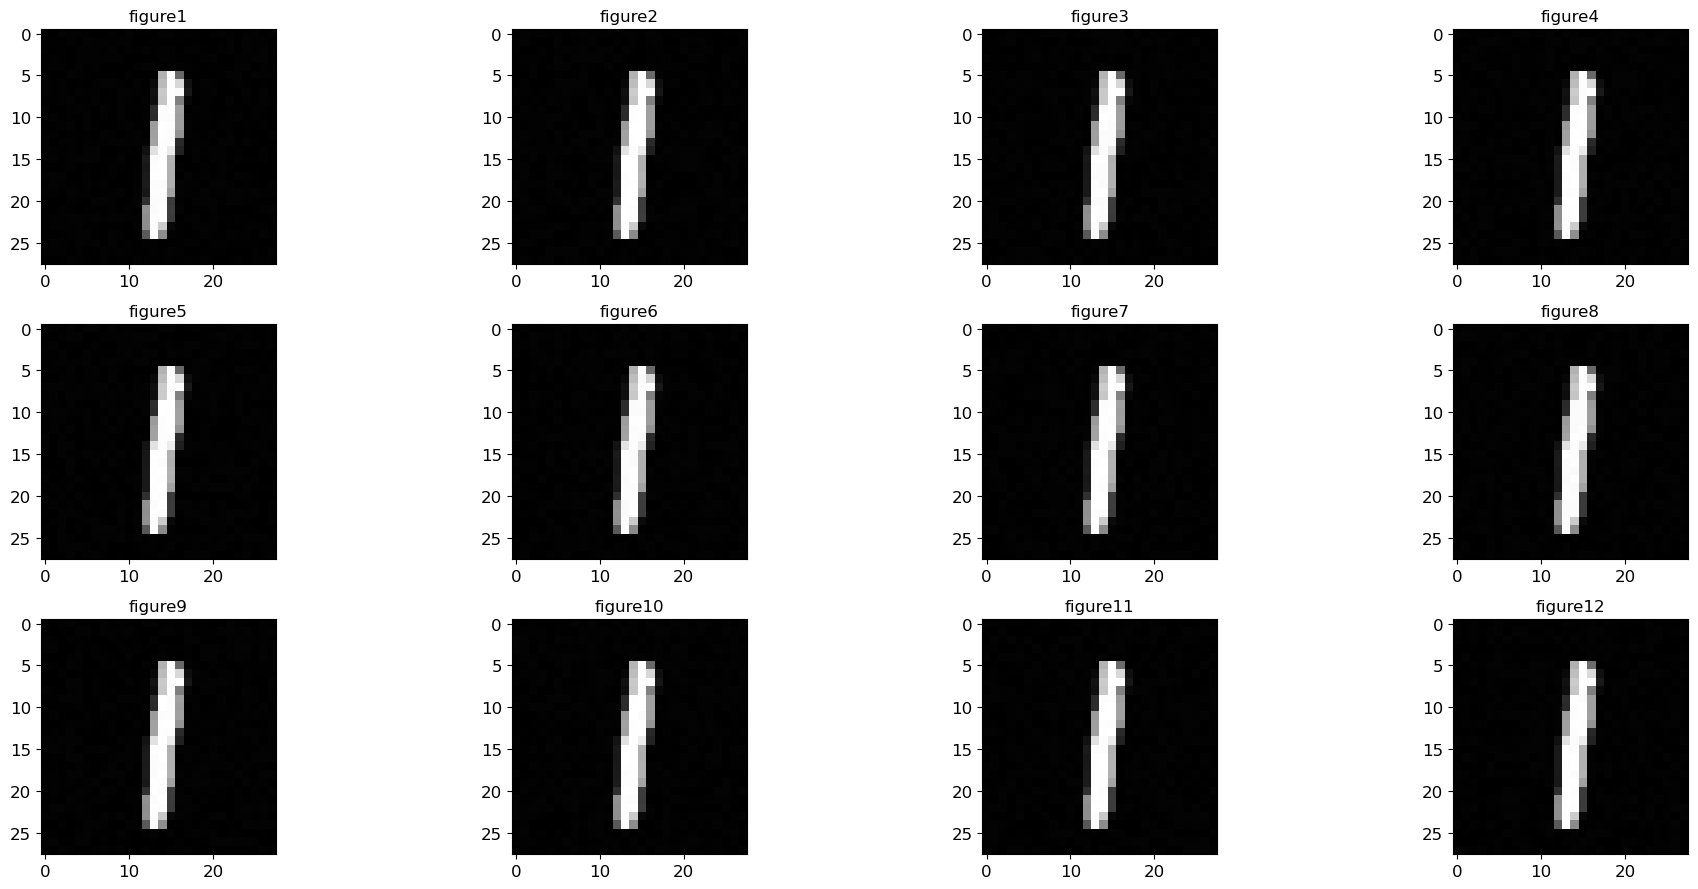

In [254]:
plot_digits(
    well_classified_noise[prediction_with_noise != class_of_well_classified][:12],
)

## CNN

In [256]:
!pip install torchsummary

In [257]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchsummary import summary

# Bonus: Convolutional Neural network (CNN)

In [272]:
x2_train = torch.from_numpy(digits_xt).view(-1, 28, 28)
x2_test = torch.from_numpy(digits_x).view(-1, 28, 28)
y2_train = torch.from_numpy(digits_yt.ravel())
y2_test = torch.from_numpy(digits_y.ravel())

train_dataset = TensorDataset(x2_train, y2_train)  # create your datset
train_loader = DataLoader(train_dataset, batch_size=300)  # create your dataloader

test_dataset = TensorDataset(x2_test, y2_test)  # create your datset
test_loader = DataLoader(test_dataset, batch_size=300)  # create your dataloader

# extract the actual data and labels
X_train = torch.unsqueeze(train_dataset.tensors[0], axis=1)
Y_train = y2_train
X_test = torch.unsqueeze(test_dataset.tensors[0], axis=1)
Y_test = y2_test

In [273]:
X_train.shape, Y_train.shape

(torch.Size([1500, 1, 28, 28]), torch.Size([1500]))

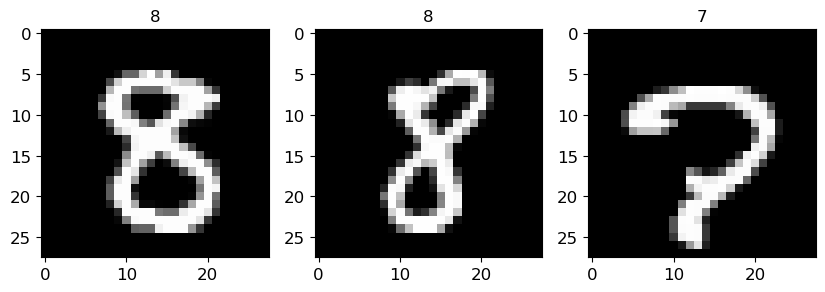

In [274]:
plt.figure(figsize=(10, 6))
for idx in range(0, 3):
    plt.subplot(1, 3, idx + 1)
    rand_ind = np.random.randint(0, train_dataset.tensors[0].shape[0])
    plt.imshow(train_dataset.tensors[0][rand_ind, :, :], cmap="gray")
    plt.title(f"{int(Y_train[rand_ind])}")

In [275]:
learning_rate = 0.01
n_epochs = 100
batch_size = 64
nb_classes = 3

# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

# --- Size of the successive layers
n_h_0 = 1  # greyscale input images
n_h_1 = nb_filters
n_h_2 = nb_filters

In [276]:
mnist_model = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=n_h_0, out_channels=n_h_1, kernel_size=kernel_size, stride=(1, 1), padding="same"),
    torch.nn.ReLU(),
    torch.nn.Conv2d(in_channels=n_h_1, out_channels=n_h_2, stride=(1, 1), padding="same", kernel_size=kernel_size),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=pool_size, stride=pool_size),
    torch.nn.Flatten(),
    torch.nn.Linear(in_features=int(28 * 28 * (1 / 4) * n_h_2), out_features=nb_classes),
)

In [277]:
print(mnist_model)

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (3): ReLU()
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=6272, out_features=3, bias=True)
)


In [278]:
summary(mnist_model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
            Conv2d-3           [-1, 32, 28, 28]           9,248
              ReLU-4           [-1, 32, 28, 28]               0
         MaxPool2d-5           [-1, 32, 14, 14]               0
           Flatten-6                 [-1, 6272]               0
            Linear-7                    [-1, 3]          18,819
Total params: 28,387
Trainable params: 28,387
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.86
Params size (MB): 0.11
Estimated Total Size (MB): 0.97
----------------------------------------------------------------


In [279]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_model.parameters(), lr=learning_rate)

In [280]:
def vector_to_class(x):
    sft = torch.nn.Softmax()(x)
    y = torch.argmax(sft, axis=1)
    return y

In [281]:
def cnn_accuracy(predict, labels):
    correct = (predict == labels).float().sum()
    accuracy = correct / predict.shape[0]
    return accuracy

In [282]:
def replace(label):
    res = label.clone()
    res[label == 7] = 1
    res[label == 8] = 2
    return res

In [283]:
def inv_replace(pred):
    res = label.clone()
    res[label == 1] = 7
    res[label == 2] = 8
    return res

In [284]:
train_losses = []

for epoch in range(0, n_epochs):
    train_loss = 0.0

    for batch_idx, (imgs, label) in enumerate(train_loader):
        # set the gradients back to 0
        # print('hhhhhhhhhhhhh',imgs.shape, label.shape,imgs.dtype, label.dtype)
        optimizer.zero_grad()
        imgs_adj = imgs.view(300, 1, 28, 28)
        predict = mnist_model(imgs_adj.float())
        labels = replace(label)
        # apply loss function
        loss = criterion(predict, labels.long())
        # backpropagation
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
    print("Epoch:{} Train Loss:{:.4f}".format(epoch, train_loss / imgs.shape[0]))
    train_losses += [train_loss / imgs.shape[0]]
    # calculate accuracy
    # print(torch.unique(inv_replace(vector_to_class(predict))),torch.unique(labels))
    print("Accuracy:{:.4f}".format(cnn_accuracy(vector_to_class(predict), labels)))

Epoch:0 Train Loss:0.0845
Accuracy:0.0000
Epoch:1 Train Loss:0.0038
Accuracy:0.0000
Epoch:2 Train Loss:0.0022
Accuracy:1.0000
Epoch:3 Train Loss:0.0049
Accuracy:0.0000
Epoch:4 Train Loss:0.0037
Accuracy:0.0000
Epoch:5 Train Loss:0.0024
Accuracy:0.4867
Epoch:6 Train Loss:0.0016
Accuracy:0.8267
Epoch:7 Train Loss:0.0012
Accuracy:0.8300
Epoch:8 Train Loss:0.0013
Accuracy:0.8100
Epoch:9 Train Loss:0.0007
Accuracy:0.9133
Epoch:10 Train Loss:0.0009
Accuracy:0.8933
Epoch:11 Train Loss:0.0007
Accuracy:0.9167
Epoch:12 Train Loss:0.0006
Accuracy:0.9300
Epoch:13 Train Loss:0.0006
Accuracy:0.9333
Epoch:14 Train Loss:0.0005
Accuracy:0.9467
Epoch:15 Train Loss:0.0005
Accuracy:0.9467
Epoch:16 Train Loss:0.0004
Accuracy:0.9467
Epoch:17 Train Loss:0.0003
Accuracy:0.9533
Epoch:18 Train Loss:0.0003
Accuracy:0.9600
Epoch:19 Train Loss:0.0003
Accuracy:0.9667
Epoch:20 Train Loss:0.0003
Accuracy:0.9700
Epoch:21 Train Loss:0.0003
Accuracy:0.9700
Epoch:22 Train Loss:0.0002
Accuracy:0.9733
Epoch:23 Train Loss:0

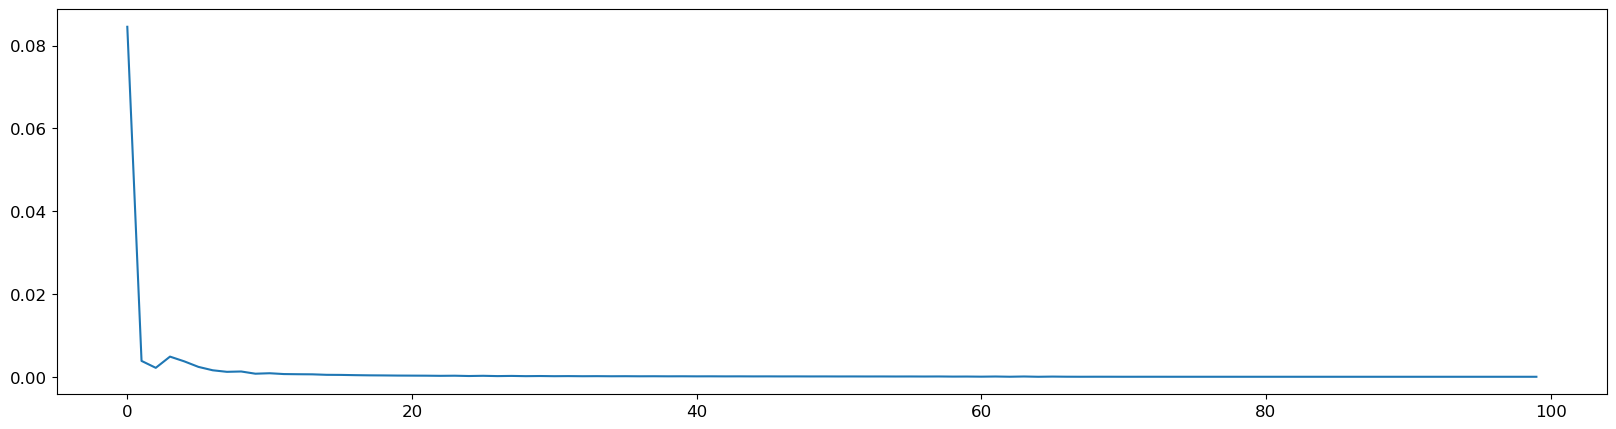

In [285]:
plt.plot(train_losses)

we notice that the accuracy is one which means that CNN performs much better than the other approaches